In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import boto3
from io import StringIO
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from datetime import timedelta
%matplotlib inline

In [2]:
#set random state for replicability
np.random.seed(1234)

In [3]:
def check_file_existence(bucket_name,folder_name,file_name):
    """
    Function checks whether or not a specified file exists in its 
    designated location. Returns True if the file exists, otherwise False. 
    """
    try:
        s3_client = boto3.client('s3')
        s3_client.head_object(Bucket=bucket_name, Key=folder_name + file_name)
        return True
    except:
        return False

def get_file(bucket_name,folder_name,file_name): 
    """
    Function checks whether or not a specified file exists in its 
    designated location. If the file exists, the function retreives it from the 
    designated s3 bucket. 
    """
    if check_file_existence(bucket_name,folder_name,file_name):
        try:
            #get the merged file and save as df
            print('Trying to get object from bucket')
            s3_client = boto3.client('s3')
            file_content = s3_client.get_object(Bucket = bucket_name, Key = folder_name + file_name)['Body'].read().decode('utf-8')
            print('Got file contents from AWS S3')
            file_df = pd.read_csv(StringIO(file_content))
            print('Saved file contents as dataframe')
            return file_df
        except Exception as e:
            return e

In [4]:
bucket_name = 'doc-daily-inmates-in-custody'
folder_name = 'data/merged_files/'
file_name = 'agg_daily_pop.csv'

adp_df = get_file(bucket_name, folder_name, file_name)
adp_df.head()

Trying to get object from bucket
Got file contents from AWS S3
Saved file contents as dataframe


,snapshot_date,race_A,race_B,race_I,race_O,race_U,race_W,gender_F,gender_Gender Unknown,gender_M,...,inmate_status_code_CSP,inmate_status_code_DE,inmate_status_code_DEP,inmate_status_code_DNS,inmate_status_code_DPV,inmate_status_code_SCO,inmate_status_code_SSR,Total Population,snapshot_month,snapshot_year
0,2021-07-26,105,3484,9,1648,33,648,295,20,5612,...,11,4456,778,79,264,4,110,5927,7,2021
1,2021-07-27,106,3469,9,1642,31,643,296,18,5586,...,12,4437,771,84,267,4,101,5900,7,2021
2,2021-07-28,106,3478,9,1648,31,640,292,18,5602,...,11,4437,769,84,269,4,110,5912,7,2021
3,2021-07-29,108,3470,9,1649,34,638,291,22,5595,...,10,4436,772,91,264,4,99,5908,7,2021
4,2021-07-30,108,3455,9,1630,33,638,285,21,5567,...,10,4412,761,83,265,4,107,5873,7,2021


In [5]:
adp_df.columns

Index(['snapshot_date', 'race_A', 'race_B', 'race_I', 'race_O', 'race_U',
       'race_W', 'gender_F', 'gender_Gender Unknown', 'gender_M',
       'population_group_Additional Groups', 'population_group_Jail Sentence',
       'population_group_Parole Violation',
       'population_group_Pretrial Detention',
       'population_group_State Prison Sentence: Awaiting Transfer', 'bradh_N',
       'bradh_Y', 'inmate_status_code_CS', 'inmate_status_code_CSP',
       'inmate_status_code_DE', 'inmate_status_code_DEP',
       'inmate_status_code_DNS', 'inmate_status_code_DPV',
       'inmate_status_code_SCO', 'inmate_status_code_SSR', 'Total Population',
       'snapshot_month', 'snapshot_year'],
      dtype='object')

In [6]:
#aggregate to 30 day intervals
#set data type
adp_df['snapshot_date'] = pd.to_datetime(adp_df['snapshot_date'])
#get latest snapshot date
max_date = adp_df['snapshot_date'].max()
#aggregate to 30 day periods
interval_data = adp_df.resample('30D', on='snapshot_date',origin = max_date,closed='right',label = 'right').mean().round().fillna(0).reset_index()
interval_data = interval_data.rename(columns = {'snapshot_date':'End Date','Total Population':'ADP'})
interval_data['Start Date'] = interval_data['End Date'] - pd.to_timedelta(29, unit='D')

#display just date of the start/end date columns localize to specific timezone or altar will assume UTC in graph
interval_data['Start Date'] = interval_data['Start Date'].dt.tz_localize('America/New_York')
interval_data['End Date'] = interval_data['End Date'].dt.tz_localize('America/New_York')

interval_data.head()

,End Date,race_A,race_B,race_I,race_O,race_U,race_W,gender_F,gender_Gender Unknown,gender_M,...,inmate_status_code_DE,inmate_status_code_DEP,inmate_status_code_DNS,inmate_status_code_DPV,inmate_status_code_SCO,inmate_status_code_SSR,ADP,snapshot_month,snapshot_year,Start Date
0,2021-08-12 00:00:00-04:00,107.0,3469.0,9.0,1647.0,29.0,645.0,288.0,17.0,5600.0,...,4451.0,758.0,84.0,268.0,3.0,100.0,5906.0,8.0,2021.0,2021-07-14 00:00:00-04:00
1,2021-09-11 00:00:00-04:00,103.0,3531.0,11.0,1695.0,27.0,644.0,296.0,16.0,5701.0,...,4583.0,755.0,68.0,270.0,3.0,92.0,6012.0,8.0,2021.0,2021-08-13 00:00:00-04:00
2,2021-10-11 00:00:00-04:00,101.0,3440.0,11.0,1663.0,29.0,604.0,280.0,15.0,5554.0,...,4626.0,687.0,59.0,195.0,3.0,109.0,5849.0,9.0,2021.0,2021-09-12 00:00:00-04:00
3,2021-11-10 00:00:00-05:00,91.0,3296.0,11.0,1560.0,24.0,551.0,258.0,13.0,5262.0,...,4544.0,532.0,70.0,139.0,2.0,134.0,5533.0,10.0,2021.0,2021-10-12 00:00:00-04:00
4,2021-12-10 00:00:00-05:00,99.0,3229.0,13.0,1532.0,22.0,512.0,242.0,10.0,5156.0,...,4485.0,456.0,91.0,104.0,2.0,137.0,5408.0,12.0,2021.0,2021-11-11 00:00:00-05:00


In [7]:
#lets only look at the total population
_30day_pop_tot = interval_data[['Start Date','End Date','ADP']]
#add date related regressors
_30day_pop_tot['Month'] = _30day_pop_tot['Start Date'].dt.month
_30day_pop_tot['Year'] = _30day_pop_tot['Start Date'].dt.year
#make a binary flag for major us holidays: New Years, Fourth of July, Labor Day, Halloween, Thanksgiving, Christmas/Hanukkah/Kwanzaa
_30day_pop_tot['Holiday'] = _30day_pop_tot['Month'].isin([1, 7, 9, 10, 11, 12]).astype(int)
#add lag term
for i in range(1,13):
    _30day_pop_tot['adp_lag'+str(i)] = _30day_pop_tot['ADP'].shift(i)

#fillnas with zero
_30day_pop_tot = _30day_pop_tot.fillna(0)
_30day_pop_tot.head()

C:\Users\emjoh\AppData\Local\Temp\ipykernel_2748\1159100851.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _30day_pop_tot['Month'] = _30day_pop_tot['Start Date'].dt.month
C:\Users\emjoh\AppData\Local\Temp\ipykernel_2748\1159100851.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _30day_pop_tot['Year'] = _30day_pop_tot['Start Date'].dt.year
C:\Users\emjoh\AppData\Local\Temp\ipykernel_2748\1159100851.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

,Start Date,End Date,ADP,Month,Year,Holiday,adp_lag1,adp_lag2,adp_lag3,adp_lag4,adp_lag5,adp_lag6,adp_lag7,adp_lag8,adp_lag9,adp_lag10,adp_lag11,adp_lag12
0,2021-07-14 00:00:00-04:00,2021-08-12 00:00:00-04:00,5906.0,7,2021,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2021-08-13 00:00:00-04:00,2021-09-11 00:00:00-04:00,6012.0,8,2021,0,5906.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2021-09-12 00:00:00-04:00,2021-10-11 00:00:00-04:00,5849.0,9,2021,1,6012.0,5906.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2021-10-12 00:00:00-04:00,2021-11-10 00:00:00-05:00,5533.0,10,2021,1,5849.0,6012.0,5906.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2021-11-11 00:00:00-05:00,2021-12-10 00:00:00-05:00,5408.0,11,2021,1,5533.0,5849.0,6012.0,5906.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
_30day_pop_tot.tail()

,Start Date,End Date,ADP,Month,Year,Holiday,adp_lag1,adp_lag2,adp_lag3,adp_lag4,adp_lag5,adp_lag6,adp_lag7,adp_lag8,adp_lag9,adp_lag10,adp_lag11,adp_lag12
27,2023-10-02 00:00:00-04:00,2023-10-31 00:00:00-04:00,6177.0,10,2023,1,6188.0,6191.0,6167.0,6063.0,6021.0,5968.0,5918.0,5925.0,5936.0,5818.0,5906.0,5893.0
28,2023-11-01 00:00:00-04:00,2023-11-30 00:00:00-05:00,6152.0,11,2023,1,6177.0,6188.0,6191.0,6167.0,6063.0,6021.0,5968.0,5918.0,5925.0,5936.0,5818.0,5906.0
29,2023-12-01 00:00:00-05:00,2023-12-30 00:00:00-05:00,6076.0,12,2023,1,6152.0,6177.0,6188.0,6191.0,6167.0,6063.0,6021.0,5968.0,5918.0,5925.0,5936.0,5818.0
30,2023-12-31 00:00:00-05:00,2024-01-29 00:00:00-05:00,6107.0,12,2023,1,6076.0,6152.0,6177.0,6188.0,6191.0,6167.0,6063.0,6021.0,5968.0,5918.0,5925.0,5936.0
31,2024-01-30 00:00:00-05:00,2024-02-28 00:00:00-05:00,6208.0,1,2024,1,6107.0,6076.0,6152.0,6177.0,6188.0,6191.0,6167.0,6063.0,6021.0,5968.0,5918.0,5925.0


In [9]:
#linear regression
#fit the model to the entire dataset and forecast
# Scale the entire dataset
sc = MinMaxScaler()
data = _30day_pop_tot.copy()

data_sc = sc.fit_transform(data.drop(columns=['Start Date', 'End Date']))

# Convert the array to a DataFrame
data_sc = pd.DataFrame(data=data_sc, columns=data.columns.to_list()[2:])

# Add constant to the dataset
data_sc = sm.add_constant(data_sc, prepend=False, has_constant='add')

# Split the dataset into features (X) and target (y)
X = data_sc.drop(columns=['ADP'])
y = data_sc['ADP']

#train test split
train_size = int(len(X) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

In [10]:
#train and test
# Fit the linear regression model on the entire dataset
model = sm.OLS(y_train, X_train).fit()

# Make in sample predictions
IS_pred = model.predict(X_train)
# Make out of  sample predictions
OS_pred = model.predict(X_test)

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    ADP   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     36.94
Date:                Thu, 29 Feb 2024   Prob (F-statistic):           3.09e-06
Time:                        11:14:31   Log-Likelihood:                 49.084
No. Observations:                  25   AIC:                            -66.17
Df Residuals:                       9   BIC:                            -46.67
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Month          0.5675      0.094      6.032      0.0

In [11]:
#plot
#inverse scale the model inputs to get IS predicts
IS_inputs = pd.concat([IS_pred,X_train.drop(columns=['const'])],axis = 1)
IS_inputs = IS_inputs.rename(columns={0:'ADP'})
IS_inputs = sc.inverse_transform(IS_inputs)
#do the same with OS data
OS_inputs = pd.concat([OS_pred,X_test.drop(columns=['const'])],axis = 1)
OS_inputs = OS_inputs.rename(columns={0:'ADP'})
OS_inputs = sc.inverse_transform(OS_inputs)

In [12]:
#accuracy in terms of non-scaled values
IS_mse = mean_squared_error(data.iloc[:train_size]['ADP'], IS_inputs[:,0])
IS_mae = mean_absolute_error(data.iloc[:train_size]['ADP'], IS_inputs[:,0])

# Make out of  sample predictions
OS_mse = mean_squared_error(data.iloc[train_size:]['ADP'], OS_inputs[:,0])
OS_mae = mean_absolute_error(data.iloc[train_size:]['ADP'], OS_inputs[:,0])

print(IS_mse, IS_mae)
print(OS_mse, OS_mae)

758.9329132907682 15.505530448218888
31060.635847116082 155.440310275334


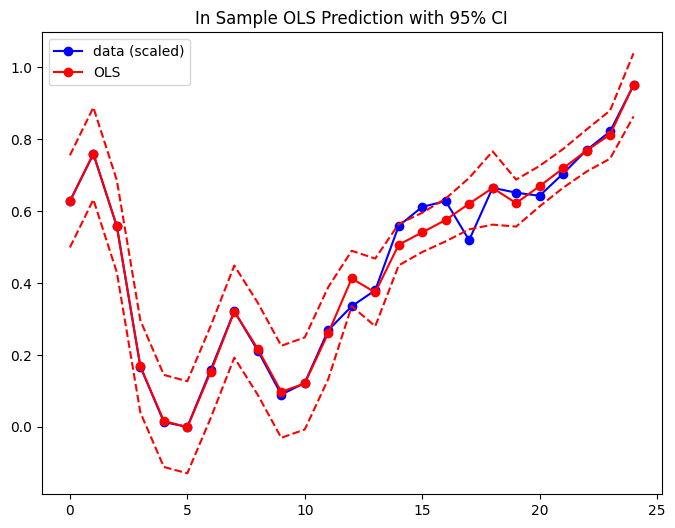

In [13]:
# Get confidence interval for the forecasted value in scaled range
ci_scaled = model.get_prediction(X_train).conf_int(alpha=0.05)

#assaign ADP value in the forecast df
lower_bound = ci_scaled[:,0]
upper_bound = ci_scaled[:,1]


fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(X_train.index, y_train, "bo-", label="data (scaled)")
ax.plot(X_train.index, IS_pred, "ro-", label="OLS")
ax.plot(X_train.index, lower_bound, "r--")
ax.plot(X_train.index, upper_bound, "r--")
ax.legend(loc="best")
plt.title('In Sample OLS Prediction with 95% CI')
plt.show()

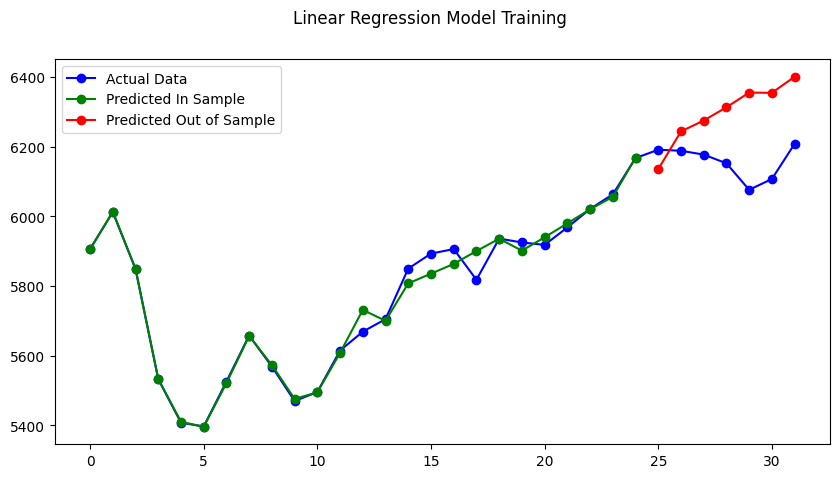

In [14]:
fig = plt.figure(figsize=(10,5))
fig.suptitle(f'Linear Regression Model Training')

actual, = plt.plot(data.index,data['ADP'], 'bo-', label='Actual Data')
predicted_IS, = plt.plot(data.iloc[:train_size].index, IS_inputs[:,0], 'go-', label='Predicted In Sample')
predicted_OS, = plt.plot(data.iloc[train_size:].index, OS_inputs[:,0], 'ro-', label='Predicted Out of Sample')

plt.legend(handles=[actual,predicted_IS,predicted_OS])
plt.show()

In [15]:
# Fit the linear regression model on the entire dataset
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    ADP   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                     25.08
Date:                Thu, 29 Feb 2024   Prob (F-statistic):           2.68e-08
Time:                        11:14:31   Log-Likelihood:                 43.317
No. Observations:                  32   AIC:                            -54.63
Df Residuals:                      16   BIC:                            -31.18
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Month          0.3688      0.081      4.565      0.0

In [16]:
# Make predictions on the test set
IS_pred = model.predict(X)

#inverse scale the model inputs to get IS predicts
IS_inputs = pd.concat([IS_pred,X.drop(columns=['const'])],axis = 1)
IS_inputs = IS_inputs.rename(columns={0:'ADP'})
IS_inputs = sc.inverse_transform(IS_inputs)

#accuracy in terms of non-scaled values
IS_mse = mean_squared_error(data['ADP'], IS_inputs[:,0])
IS_mae = mean_absolute_error(data['ADP'], IS_inputs[:,0])

print(IS_mse, IS_mae)

2569.1770984382183 35.9877425401819


In [17]:
#now that we fit the model, lets predict 12 timestamps in the future
# Forecast the next 12 months
#last time stamp from data
last_start_date = data['Start Date'].iloc[-1]
forecast_start_dates = pd.Series()

for i in range(2, 15):
    forecast_start_dates.at[i-2] = last_start_date + timedelta(days=30 * i)
# Create a DataFrame for the next 12 months with the same structure as your dataset
forecast_data = pd.DataFrame(columns = data.columns.to_list()[2:])
forecast_data['ADP'] = np.zeros(12) #placeholder for the minmaxscaler

# Fill in other features like Month, Year, and Holiday (adjust as needed)
forecast_data['Month'] = forecast_start_dates.dt.month # Set the month for forecasting
forecast_data['Year'] = forecast_start_dates.dt.year # Set the year for forecasting
forecast_data['Holiday'] = forecast_data['Month'].isin([1, 7, 9, 10, 11, 12]).astype(int) # Set the holiday flag for forecasting

# Fill in the values for lag terms using the actual values from the dataset
# Since the lags are dependent on the ADP IV, we should predict 1 time stamp ahead 12 independent times
# so we can use the previously predicted ADP value in the lag calculation

#since we have all the lag data for the first prediction, we will do this calculation seperately
forecast_data.iloc[0,4:] = data['ADP'].shift(0).iloc[-12:][::-1].reset_index(drop = True)
forecast_data

,ADP,Month,Year,Holiday,adp_lag1,adp_lag2,adp_lag3,adp_lag4,adp_lag5,adp_lag6,adp_lag7,adp_lag8,adp_lag9,adp_lag10,adp_lag11,adp_lag12
0,0.0,3,2024,0,6208.0,6107.0,6076.0,6152.0,6177.0,6188.0,6191.0,6167.0,6063.0,6021.0,5968.0,5918.0
1,0.0,4,2024,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,5,2024,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,6,2024,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,7,2024,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.0,8,2024,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.0,9,2024,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0.0,10,2024,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.0,11,2024,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.0,12,2024,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
#since we have all the lag data for the first prediction, we will do this calculation seperately
# Reshape the one-dimensional array before scaling

#create two empty columns to report the lower and upper ci of forecast
forecast_data['lower_bound'] = np.zeros(12)
forecast_data['upper_bound'] = np.zeros(12)

for i in range(0,12):
    forecast_data_scaled = sc.transform(forecast_data.iloc[i,:-2].values.reshape(1, -1))

    # Convert the scaled array back to a DataFrame
    forecast_df_scaled = pd.Series(data = forecast_data_scaled[0], index=forecast_data.columns.to_list()[:-2])
    lower_bound_df = pd.Series(data = forecast_data_scaled[0], index=forecast_data.columns.to_list()[:-2])
    upper_bound_df = pd.Series(data = forecast_data_scaled[0], index=forecast_data.columns.to_list()[:-2])
    # Add the constant to the DataFrame
    forecast_df_scaled['const'] = 1
    lower_bound_df['const'] = 1
    upper_bound_df['const'] = 1

    # Make predictions using the trained model, exclude ADP value
    forecast_predictions = model.predict(forecast_df_scaled[1:])
    # Get confidence interval for the forecasted value in scaled range
    forecast_ci_scaled = model.get_prediction(forecast_df_scaled[1:]).conf_int(alpha=0.05)

    #assaign ADP value in the forecast df
    forecast_df_scaled.iloc[0] = forecast_predictions
    lower_bound_df.iloc[0] = forecast_ci_scaled[0, 0]
    upper_bound_df.iloc[0] = forecast_ci_scaled[0, 1]

    scaled_result_df = forecast_df_scaled.to_frame().T
    lower_bound_df = lower_bound_df.to_frame().T
    upper_bound_df = upper_bound_df.to_frame().T

    actual_results = sc.inverse_transform(scaled_result_df.drop(columns=['const']))
    lower_bound_results = sc.inverse_transform(lower_bound_df.drop(columns=['const']))
    upper_bound_df = sc.inverse_transform(upper_bound_df.drop(columns=['const']))

    #set ADP value equal to the predicted ADP value
    forecast_data.iloc[i,0] = actual_results[0][0].round()
    forecast_data.iloc[i,-2] = lower_bound_results[0][0].round()
    forecast_data.iloc[i,-1] = upper_bound_df[0][0].round()

    #get next prediction regressors
    if i == 11:
        break
    else:
        #add the last predicted adp as adp_1 for this row
        forecast_data.iloc[i+1,4] = actual_results[0][0].round()
        #shift the lags
        forecast_data.iloc[i+1,5:-2] = forecast_data.iloc[i,4:15]
forecast_data

c:\Users\emjoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\emjoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\emjoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\emjoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\emjoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fit

,ADP,Month,Year,Holiday,adp_lag1,adp_lag2,adp_lag3,adp_lag4,adp_lag5,adp_lag6,adp_lag7,adp_lag8,adp_lag9,adp_lag10,adp_lag11,adp_lag12,lower_bound,upper_bound
0,6304.0,3,2024,0,6208.0,6107.0,6076.0,6152.0,6177.0,6188.0,6191.0,6167.0,6063.0,6021.0,5968.0,5918.0,6210.0,6398.0
1,6329.0,4,2024,0,6304.0,6208.0,6107.0,6076.0,6152.0,6177.0,6188.0,6191.0,6167.0,6063.0,6021.0,5968.0,6232.0,6426.0
2,6348.0,5,2024,0,6329.0,6304.0,6208.0,6107.0,6076.0,6152.0,6177.0,6188.0,6191.0,6167.0,6063.0,6021.0,6247.0,6450.0
3,6368.0,6,2024,0,6348.0,6329.0,6304.0,6208.0,6107.0,6076.0,6152.0,6177.0,6188.0,6191.0,6167.0,6063.0,6262.0,6475.0
4,6409.0,7,2024,1,6368.0,6348.0,6329.0,6304.0,6208.0,6107.0,6076.0,6152.0,6177.0,6188.0,6191.0,6167.0,6313.0,6505.0
5,6420.0,8,2024,0,6409.0,6368.0,6348.0,6329.0,6304.0,6208.0,6107.0,6076.0,6152.0,6177.0,6188.0,6191.0,6299.0,6540.0
6,6463.0,9,2024,1,6420.0,6409.0,6368.0,6348.0,6329.0,6304.0,6208.0,6107.0,6076.0,6152.0,6177.0,6188.0,6358.0,6569.0
7,6487.0,10,2024,1,6463.0,6420.0,6409.0,6368.0,6348.0,6329.0,6304.0,6208.0,6107.0,6076.0,6152.0,6177.0,6375.0,6599.0
8,6507.0,11,2024,1,6487.0,6463.0,6420.0,6409.0,6368.0,6348.0,6329.0,6304.0,6208.0,6107.0,6076.0,6152.0,6387.0,6626.0
9,6528.0,12,2024,1,6507.0,6487.0,6463.0,6420.0,6409.0,6368.0,6348.0,6329.0,6304.0,6208.0,6107.0,6076.0,6400.0,6656.0


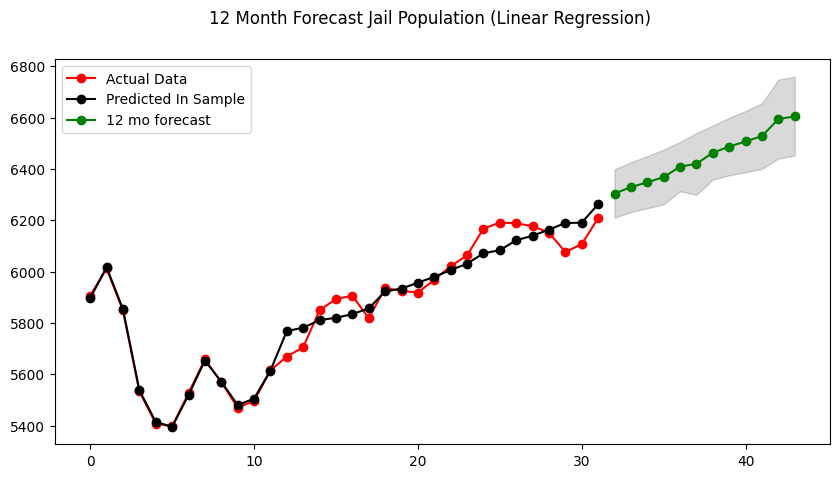

In [19]:
#plot actual data and forecast
#turn IS predicts into a dataframe with column names
IS_predicted_counts = pd.DataFrame(data = IS_inputs, columns = data.columns.to_list()[2:])
fc_12mo = forecast_data['ADP']

fig = plt.figure(figsize = (10,5))
fig.suptitle(f'12 Month Forecast Jail Population (Linear Regression)')
actual, = plt.plot(data.index,data.ADP, 'ro-', label='Actual Data')
predicted_IS, = plt.plot(IS_predicted_counts.index, IS_predicted_counts['ADP'], 'ko-', label='Predicted In Sample')
fc, = plt.plot(range(len(IS_inputs),len(IS_inputs)+len(fc_12mo)), fc_12mo, 'go-', label='12 mo forecast')
plt.fill_between(range(len(IS_inputs),len(IS_inputs)+len(fc_12mo)), forecast_data['lower_bound'], forecast_data['upper_bound'], color='k', alpha=.15) # conf

plt.legend(handles=[actual,predicted_IS,fc])
plt.show()

### Compare results to the Linear Regression after feature engineering & selection

The model we are choosing is trained on:

1. Date_Rank: Discrete numeric ranging from 0 to n where n is the last date period ranked in ascending order.

2. monthly admission count

3. adp_lag4: the average daily population 4 months prior to the current time period

However, since we need the monthly admission count as a regressor in the prediction, we also need to predict this quantity. I am going to do so using an ARIMA model because this dataset has more seasonality than the ADP data.

In [20]:
import urllib.request
import json

admit_url = 'https://data.cityofnewyork.us/resource/6teu-xtgp.json'

# # Define the SQL query separately
# sql_query = ("SELECT "
#              "date_extract_y(ADMITTED_DT) as Year, "
#              "date_extract_m(ADMITTED_DT) as Month, "
#              "count(distinct INMATEID) as admission_count "
#              "WHERE date_extract_y(ADMITTED_DT) >= '2021' "
#              "GROUP BY Year, Month "
#              "LIMIT 10000")

# # Encode SQL query for URL
# encoded_query = urllib.parse.quote(sql_query)

# # Construct the full URL query
# admit_query = f'{admit_url}?$query={encoded_query}'

# # Send the request and load the response data
# response = urllib.request.urlopen(admit_query)
# data = json.loads(response.read())

# # Store in dataframe
# admit_df = pd.DataFrame(data, columns=data[0].keys())
# admit_df.head()

In [21]:
# Define the SQL query separately
first_st_date_adp = _30day_pop_tot.iloc[0]['Start Date'].date()
print(first_st_date_adp)
sql_query = ("SELECT "
             "date_trunc_ymd(ADMITTED_DT) as admitted_dt, "
             "count(distinct INMATEID) as admission_count "
             f"WHERE ADMITTED_DT >= '{first_st_date_adp}' "
             "GROUP BY admitted_dt "
             "LIMIT 10000")

# Encode SQL query for URL
encoded_query = urllib.parse.quote(sql_query)

# Construct the full URL query
admit_query = f'{admit_url}?$query={encoded_query}'
print(admit_query)
# Send the request and load the response data
response = urllib.request.urlopen(admit_query)
data = json.loads(response.read())

# Store in dataframe
admit_df = pd.DataFrame(data, columns=data[0].keys())

2021-07-14
https://data.cityofnewyork.us/resource/6teu-xtgp.json?$query=SELECT%20date_trunc_ymd%28ADMITTED_DT%29%20as%20admitted_dt%2C%20count%28distinct%20INMATEID%29%20as%20admission_count%20WHERE%20ADMITTED_DT%20%3E%3D%20%272021-07-14%27%20GROUP%20BY%20admitted_dt%20LIMIT%2010000


In [22]:
admit_df.head()

,admitted_dt,admission_count
0,2021-07-14T00:00:00.000,61
1,2021-07-15T00:00:00.000,45
2,2021-07-16T00:00:00.000,59
3,2021-07-17T00:00:00.000,40
4,2021-07-18T00:00:00.000,45


In [23]:
admit_df['admitted_dt'] = admit_df['admitted_dt'].astype('datetime64[ns]')
admit_df['admission_count'] = admit_df['admission_count'].astype(int)
admit_df.dtypes

admitted_dt        datetime64[ns]
admission_count             int32
dtype: object

In [24]:
max_date = admit_df['admitted_dt'].max()
min_date = admit_df['admitted_dt'].min()
print(min_date,max_date)

2021-07-14 00:00:00 2024-01-31 00:00:00


In [25]:
#aggregate to 30 day intervals

# Resample the DataFrame to 30-day intervals
interval_data_adm = admit_df.resample('30D', on='admitted_dt', origin= min_date, closed='left', label='left').agg({'admission_count': 'sum'}).fillna(0).reset_index()

# Rename columns
interval_data_adm = interval_data_adm.rename(columns={'admitted_dt': 'Start Date', 'admission_count': 'admission_count'})

# Calculate the Start Date column
interval_data_adm['End Date'] = interval_data_adm['Start Date'] + pd.to_timedelta(29, unit='D')
#add date related regressors
interval_data_adm['Month'] = interval_data_adm['Start Date'].dt.month
interval_data_adm['Year'] = interval_data_adm['Start Date'].dt.year

#calculate the days between start period and last date in admission df
interval_data_adm['Days to Max Adm Date'] = (max_date - interval_data_adm['Start Date']).dt.days

# Display just the date portion of the start/end date columns and localize to specific timezone
interval_data_adm['Start Date'] = interval_data_adm['Start Date'].dt.tz_localize('America/New_York').dt.date
interval_data_adm['End Date'] = interval_data_adm['End Date'].dt.tz_localize('America/New_York').dt.date
# Display the resulting DataFrame
interval_data_adm.head()

,Start Date,admission_count,End Date,Month,Year,Days to Max Adm Date
0,2021-07-14,1568,2021-08-12,7,2021,931
1,2021-08-13,1372,2021-09-11,8,2021,901
2,2021-09-12,1320,2021-10-11,9,2021,871
3,2021-10-12,1291,2021-11-10,10,2021,841
4,2021-11-11,1284,2021-12-10,11,2021,811


In [26]:
interval_data_adm.tail()

,Start Date,admission_count,End Date,Month,Year,Days to Max Adm Date
27,2023-10-02,1805,2023-10-31,10,2023,121
28,2023-11-01,1816,2023-11-30,11,2023,91
29,2023-12-01,1577,2023-12-30,12,2023,61
30,2023-12-31,1813,2024-01-29,12,2023,31
31,2024-01-30,152,2024-02-28,1,2024,1


In [27]:
#make sure the last data point has a reasonable admission count
#if the period has less than 30 days of admission data, we will use the avg of the last two data points
#as the adjusted admission count for the given time period

adj_admission_count = []
for i, row in interval_data_adm.iterrows():
    if row['Days to Max Adm Date'] < 30:
        adj_adm_cnt = (interval_data_adm.iloc[i-1,interval_data_adm.columns.get_loc('admission_count')] +
                       interval_data_adm.iloc[i-2,interval_data_adm.columns.get_loc('admission_count')]) / 2
        adj_admission_count.append(round(adj_adm_cnt))
    else:
        adj_admission_count.append(row['admission_count'])
interval_data_adm['Adjusted Admission Count'] = adj_admission_count
interval_data_adm.tail()

,Start Date,admission_count,End Date,Month,Year,Days to Max Adm Date,Adjusted Admission Count
27,2023-10-02,1805,2023-10-31,10,2023,121,1805
28,2023-11-01,1816,2023-11-30,11,2023,91,1816
29,2023-12-01,1577,2023-12-30,12,2023,61,1577
30,2023-12-31,1813,2024-01-29,12,2023,31,1813
31,2024-01-30,152,2024-02-28,1,2024,1,1695


In [28]:
_30day_pop_tot = _30day_pop_tot.merge(interval_data_adm[['Year', 'Month','Adjusted Admission Count']], 
                                    how = 'left', left_on = ['Year','Month'], right_on = ['Year','Month'])
#finally lets add a unique id for month-year ranks from earliest to latest date
_30day_pop_tot['Date_Rank'] = _30day_pop_tot.sort_values(by = ['Year','Month']).index

In [29]:
_30day_pop_tot.head()

,Start Date,End Date,ADP,Month,Year,Holiday,adp_lag1,adp_lag2,adp_lag3,adp_lag4,adp_lag5,adp_lag6,adp_lag7,adp_lag8,adp_lag9,adp_lag10,adp_lag11,adp_lag12,Adjusted Admission Count,Date_Rank
0,2021-07-14 00:00:00-04:00,2021-08-12 00:00:00-04:00,5906.0,7,2021,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1568,0
1,2021-08-13 00:00:00-04:00,2021-09-11 00:00:00-04:00,6012.0,8,2021,0,5906.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1372,1
2,2021-09-12 00:00:00-04:00,2021-10-11 00:00:00-04:00,5849.0,9,2021,1,6012.0,5906.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1320,2
3,2021-10-12 00:00:00-04:00,2021-11-10 00:00:00-05:00,5533.0,10,2021,1,5849.0,6012.0,5906.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1291,3
4,2021-11-11 00:00:00-05:00,2021-12-10 00:00:00-05:00,5408.0,11,2021,1,5533.0,5849.0,6012.0,5906.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1284,4


In [30]:
#select only relevant data
final_df = _30day_pop_tot[['ADP','Date_Rank','Adjusted Admission Count', 'adp_lag4']]
final_df.head()

,ADP,Date_Rank,Adjusted Admission Count,adp_lag4
0,5906.0,0,1568,0.0
1,6012.0,1,1372,0.0
2,5849.0,2,1320,0.0
3,5533.0,3,1291,0.0
4,5408.0,4,1284,5906.0


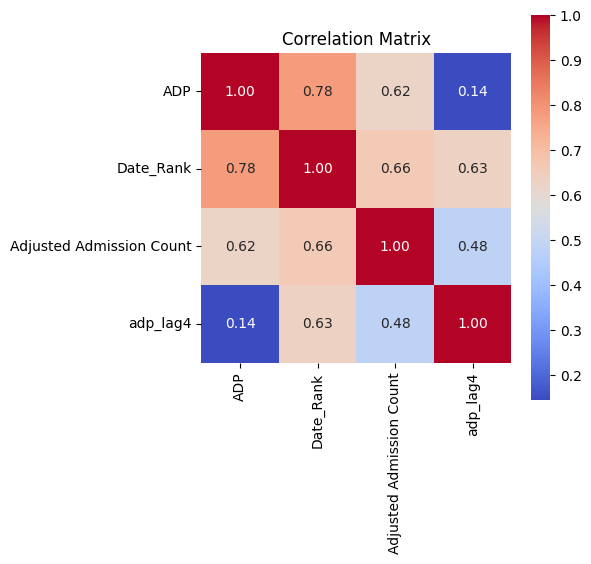

In [31]:
import seaborn as sns

# Calculating correlation matrix
correlation_matrix = final_df.corr()

# Plotting correlation matrix using seaborn
plt.figure(figsize=(5, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt="0.2f", square=True)
plt.title('Correlation Matrix')
plt.show()

In [32]:
#import arima packages
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa import arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf,adfuller, kpss,range_unit_root_test # BDS for inped
from statsmodels.tsa.stattools import q_stat #Compute Ljung-Box Q Statistic.
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

Decompose the signal into trend, seasonality, and residuals

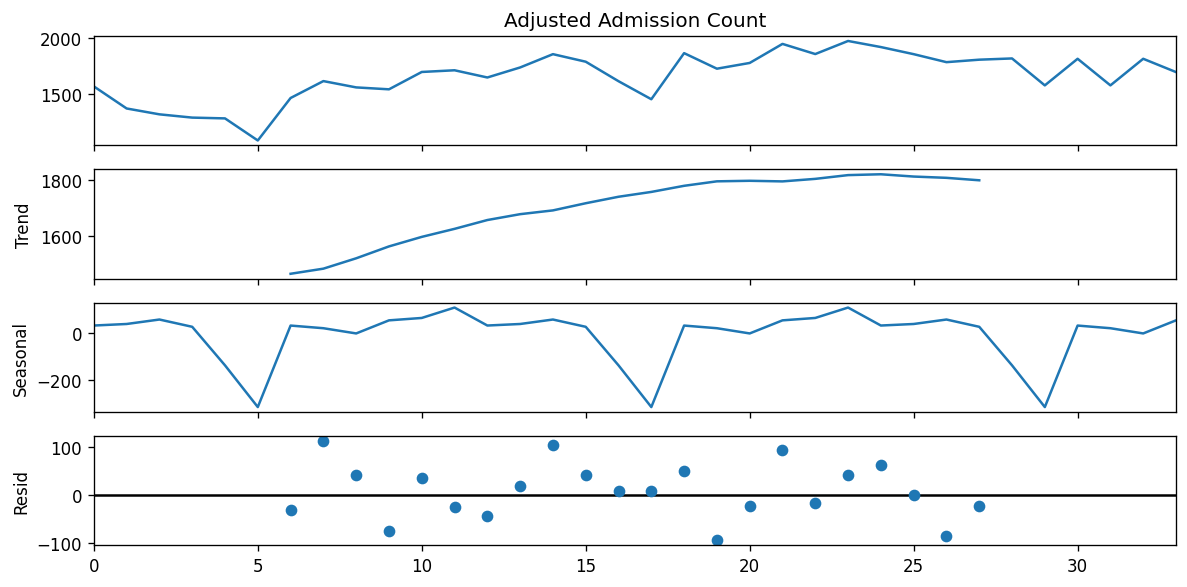

In [33]:
#decompose the monthly admission count
results = seasonal_decompose(final_df['Adjusted Admission Count'],model='additive',period=12)
plt.rcParams.update({'figure.figsize':(10,5), 'figure.dpi':120})
results.plot()
plt.show()

Determine stationality of signal

In [34]:
result = adfuller(final_df['Adjusted Admission Count'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.295006
p-value: 0.173584
Critical Values:
	1%: -3.646
	5%: -2.954
	10%: -2.616


Based on the p-value for the adf test above, the signal is not stationary. Let's determine the differencing order we need to use for our ARIMA model.

In [35]:
result = adfuller(final_df['Adjusted Admission Count'].diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -8.404908
p-value: 0.000000
Critical Values:
	1%: -3.654
	5%: -2.957
	10%: -2.618


The 1st difference of the series is stationary with a confidence level of 95%. Let's now investigate the PACF and ACF of the original and differenced series.

Text(0.5, 1.0, 'Partial Autocorrelation')

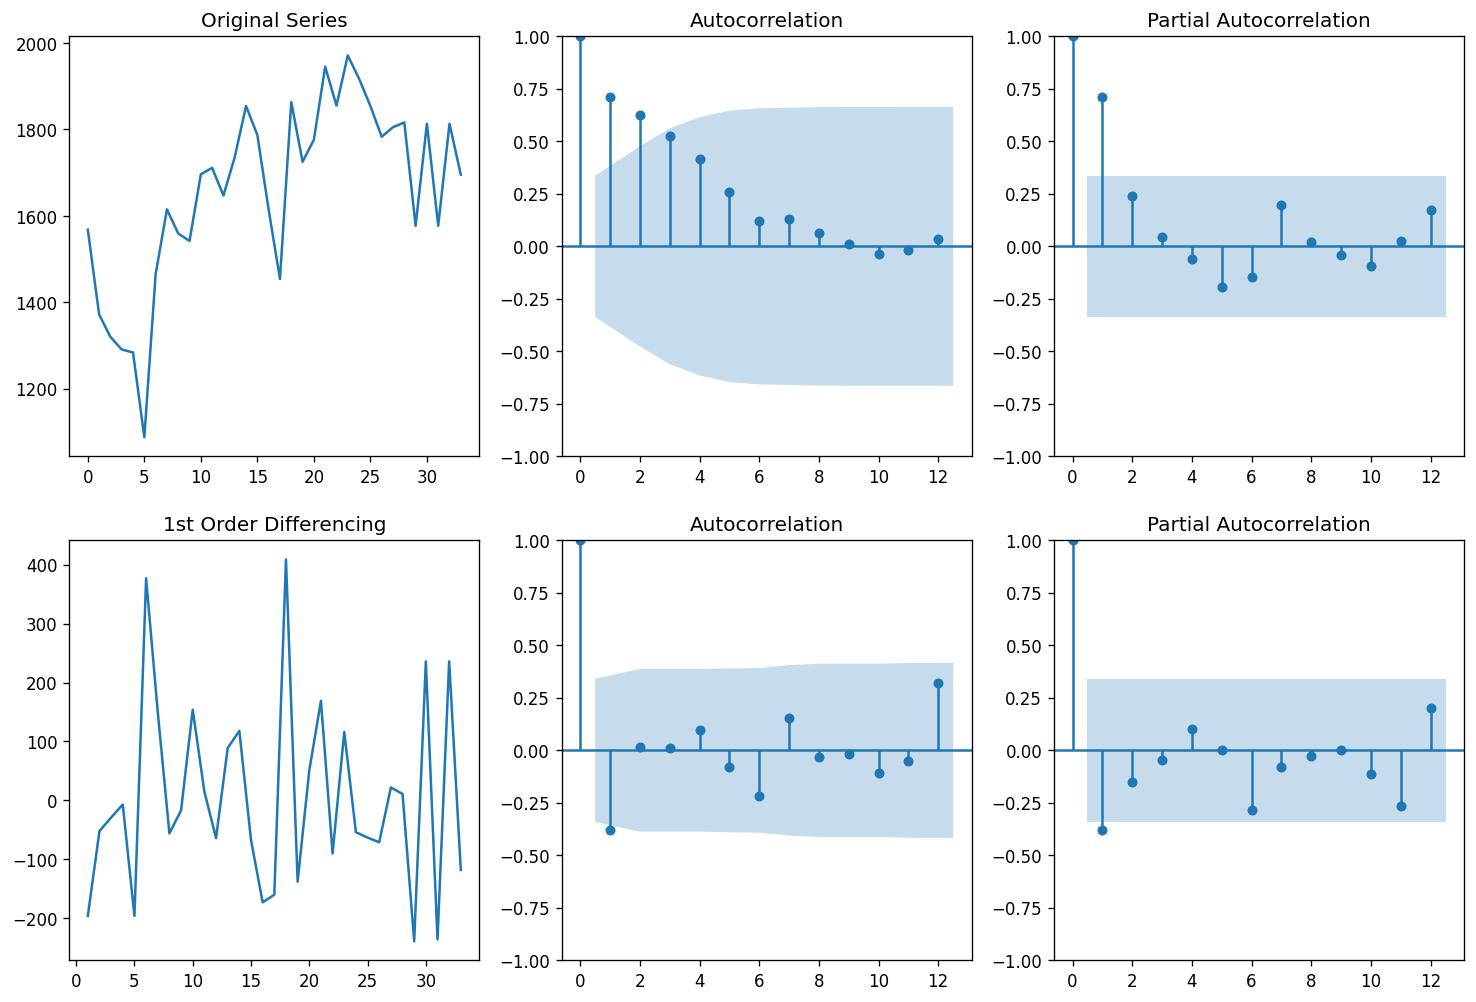

In [36]:
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(15,10), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(2, 3)
axes[0, 0].plot(final_df['Adjusted Admission Count']); axes[0, 0].set_title('Original Series')

plot_acf(final_df['Adjusted Admission Count'], lags = 12, ax = axes[0, 1])
axes[0, 1].set_title('Autocorrelation')

plot_pacf(final_df['Adjusted Admission Count'], lags = 12, ax=axes[0, 2])
axes[0, 2].set_title('Partial Autocorrelation')


# 1st Differencing
axes[1, 0].plot(final_df['Adjusted Admission Count'].diff()); axes[1, 0].set_title('1st Order Differencing')

plot_acf(final_df['Adjusted Admission Count'].diff().dropna(), lags = 12, ax = axes[1, 1])
axes[1, 1].set_title('Autocorrelation')

plot_pacf(final_df['Adjusted Admission Count'].diff().dropna(), lags = 12, ax=axes[1, 2])
axes[1, 2].set_title('Partial Autocorrelation')

### Rules for identifying the numbers of AR and MA terms:

* Rule 1: If the partial autocorrelation function (PACF) of the differenced series displays a sharp cutoff and/or the lag-1 autocorrelation is positive--i.e., if the series appears slightly "underdifferenced"--then consider adding one or more AR terms to the model. The lag beyond which the PACF cuts off is the indicated number of AR terms.

* Rule 2: If the autocorrelation function (ACF) of the differenced series displays a sharp cutoff and/or the lag-1 autocorrelation is negative--i.e., if the series appears slightly "overdifferenced"--then consider adding an MA term to the model. The lag beyond which the ACF cuts off is the indicated number of MA terms.

* Rule 3: It is possible for an AR term and an MA term to cancel each other's effects, so if a mixed AR-MA model seems to fit the data, also try a model with one fewer AR term and one fewer MA term--particularly if the parameter estimates in the original model require more than 10 iterations to converge. BEWARE OF USING MULTIPLE AR TERMS AND MULTIPLE MA TERMS IN THE SAME MODEL.

Recall that:

* **q:** The size of the moving average window, or the number of the moving average terms, also called the order of moving average.

* **p:** The number of AR terms included in the model, also called the lag order.

Autoregressive models: AR(p)

moving average models: MA(q)

mixed autoregressive moving average models: ARMA(p, q)

integration models: ARIMA(p, d, q)

seasonal models: SARIMA(P, D, Q, s)

It seems like we want an ARIMA model with d = 1, p = 0 and q = 2. Lets see how this model performs when trained on 80% of our data and tested on the additional 20%.

In [37]:
p=0
d=1
q=2
order = (p,d,q)
# fit model
series = final_df['Adjusted Admission Count']
train_size = int(len(series)*0.8)
#train test split
series_train =  series.iloc[:train_size]
series_test = series.iloc[train_size:]

model = sm.tsa.ARIMA(series_train, order=order)
model_fit = model.fit()
pred = model_fit.get_forecast(steps=len(series_test))
mae = mean_absolute_error(series_test, pred.predicted_mean)
print('The out of sample MAE is: ', mae)
print(model_fit.summary())

The out of sample MAE is:  100.16825559246682
                                  SARIMAX Results                                   
Dep. Variable:     Adjusted Admission Count   No. Observations:                   27
Model:                       ARIMA(0, 1, 2)   Log Likelihood                -166.324
Date:                      Thu, 29 Feb 2024   AIC                            338.649
Time:                              11:14:34   BIC                            342.423
Sample:                                   0   HQIC                           339.736
                                       - 27                                         
Covariance Type:                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2741      0.201     -1.361      0.173      -0.669       0.121
ma.L2         -0.1860      0.244     

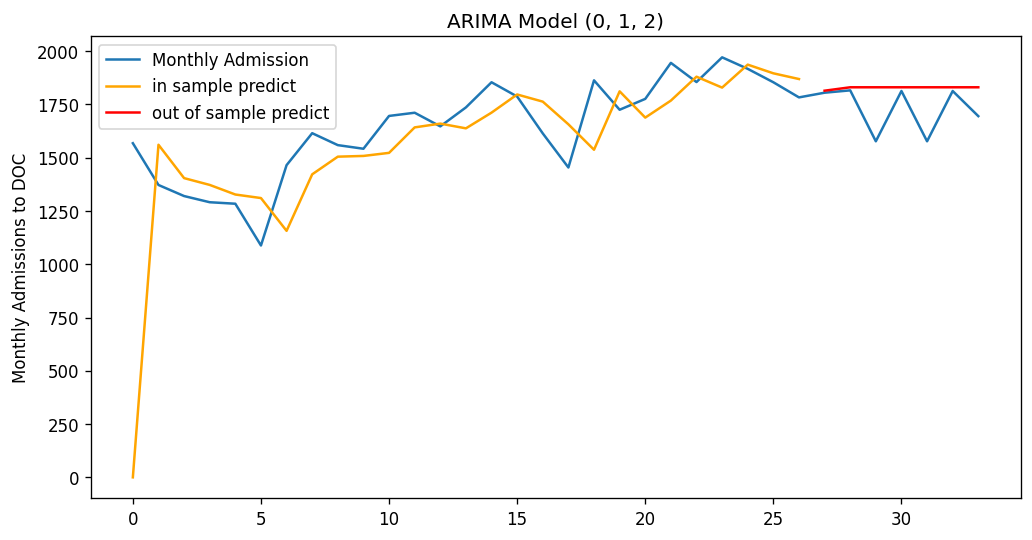

In [38]:
#plot
# Perform in-sample predictions
train_predictions = model_fit.predict()
fc_series = pd.Series(pred.summary_frame()['mean'].values)

plt.rcParams.update({'figure.figsize':(10,5)})
fig, ax = plt.subplots()
ax.plot(series.index,series,label='Monthly Admission') # train
ax.plot(series_train.index,train_predictions,color='orange',label='in sample predict') # in-sample
ax.plot(series_test.index,fc_series,color='red',label='out of sample predict') # out of sample

plt.xlabel('')
plt.ylabel('Monthly Admissions to DOC')
plt.title(f'ARIMA Model {order}')
plt.legend()
plt.show()

Now let's try a model with a 12 month seasonal coefficient. We should look at the seasonal signal to determine the best coefficients for the seasonal order.

In [39]:
#see if the seasonal signal is stationary or not
result = adfuller(results.seasonal)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -217872887414341.250000
p-value: 0.000000
Critical Values:
	1%: -3.753
	5%: -2.998
	10%: -2.639


The seasonal signal is stationary so D = 0. Let's check out the ACF and PACF charts

Text(0.5, 1.0, 'Partial Autocorrelation')

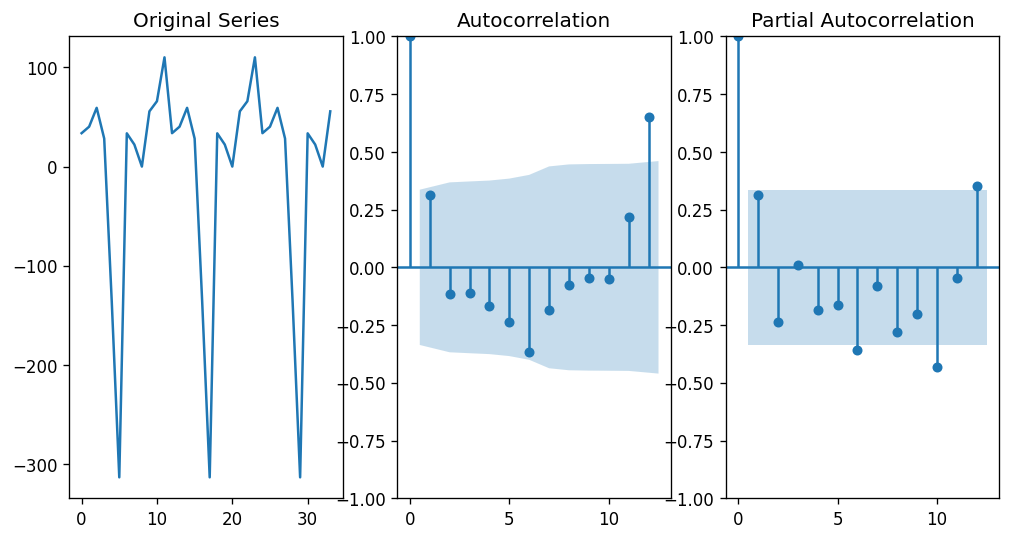

In [40]:
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(10,5), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(1, 3)
axes[0].plot(results.seasonal); axes[0].set_title('Original Series')

plot_acf(results.seasonal, lags = 12, ax = axes[1])
axes[1].set_title('Autocorrelation')

plot_pacf(results.seasonal, lags = 12, ax=axes[2])
axes[2].set_title('Partial Autocorrelation')

In [1]:
p=0
d=1
q=1
order = (p,d,q)
seasonal_order = (1,0,0,12)

model = sm.tsa.ARIMA(series_train, order=order,seasonal_order=seasonal_order)
model_fit = model.fit()
pred = model_fit.get_forecast(steps=len(series_test))
mae = mean_absolute_error(series_test, pred.predicted_mean)
print('The out of sample MAE is: ', mae.round(2))
print(model_fit.summary())

NameError: name 'sm' is not defined

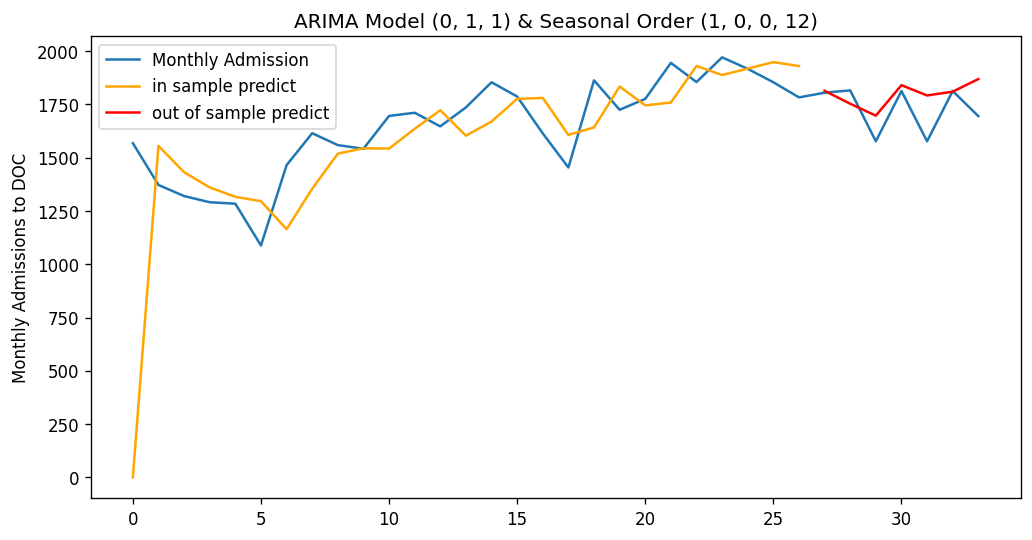

In [42]:
#plot
# Perform in-sample predictions
train_predictions = model_fit.predict()
fc_series = pd.Series(pred.summary_frame()['mean'].values)

plt.rcParams.update({'figure.figsize':(10,5)})
fig, ax = plt.subplots()
ax.plot(series.index,series,label='Monthly Admission') # train
ax.plot(series_train.index,train_predictions,color='orange',label='in sample predict') # in-sample
ax.plot(series_test.index,fc_series,color='red',label='out of sample predict') # out of sample

plt.xlabel('')
plt.ylabel('Monthly Admissions to DOC')
plt.title(f'ARIMA Model {order} & Seasonal Order {seasonal_order}')
plt.legend()
plt.show()

Now let's forecast 12 data points into the future to use as regressors for our linear regression model.

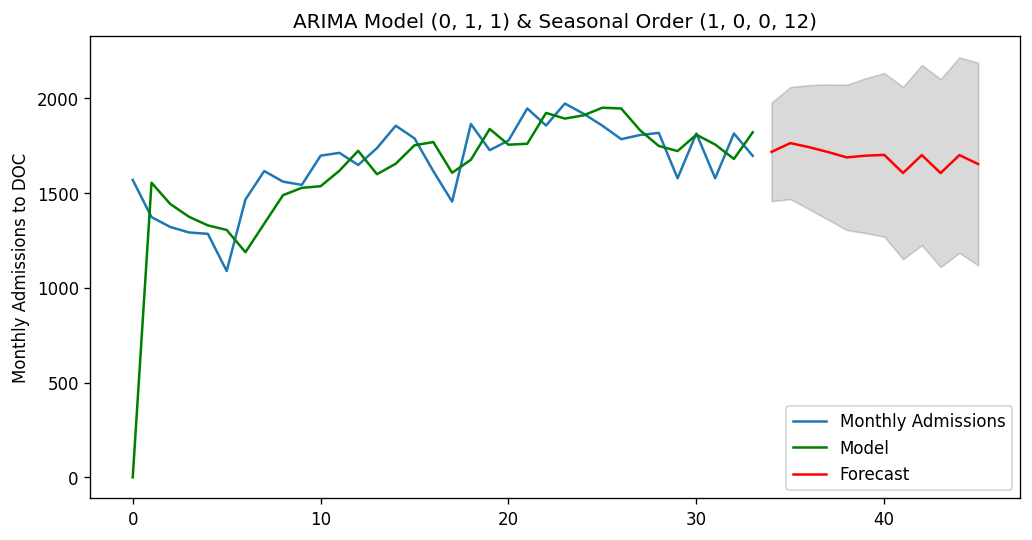

In [43]:
#fit model to data
p=0
d=1
q=1
order = (p,d,q)
seasonal_order = (1,0,0,12)

model = sm.tsa.ARIMA(series, order=order,seasonal_order=seasonal_order)
model_fit = model.fit()
# Perform in-sample predictions
train_predictions = model_fit.predict()
#forecast
pred = model_fit.get_forecast(steps=12)
fc_series = pd.Series(pred.summary_frame()['mean'].values)
#plot just forecast and CI

fc = pred.summary_frame()
lower_series = pd.Series(fc.mean_ci_lower, index=fc.index)
upper_series = pd.Series(fc.mean_ci_upper, index=fc.index)

plt.rcParams.update({'figure.figsize':(10,5)})
fig, ax = plt.subplots()
ax.plot(series.index,series,label='Monthly Admissions') # ACTUAL DATA
ax.plot(series.index,train_predictions,color='green',label='Model') # MODEL
ax.plot(fc.index,fc_series,color='red',label='Forecast') # 12 MONTH FORECAST
ax.fill_between(fc.index, lower_series, upper_series, color='k', alpha=.15) # conf

plt.xlabel('')
plt.ylabel('Monthly Admissions to DOC')
plt.title(f'ARIMA Model {order} & Seasonal Order {seasonal_order}')
plt.legend(loc = 'lower right')
plt.show()

In [44]:
print(model_fit.summary())

                                     SARIMAX Results                                     
Dep. Variable:          Adjusted Admission Count   No. Observations:                   34
Model:             ARIMA(0, 1, 1)x(1, 0, [], 12)   Log Likelihood                -209.143
Date:                           Thu, 29 Feb 2024   AIC                            424.287
Time:                                   11:14:35   BIC                            428.776
Sample:                                        0   HQIC                           425.797
                                            - 34                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4584      0.174     -2.638      0.008      -0.799      -0.118
ar.S.L12       0.4008      0.195      2.053

In [45]:
fc

Adjusted Admission Count,mean,mean_se,mean_ci_lower,mean_ci_upper
34,1715.892495,132.607826,1455.985932,1975.799059
35,1762.389231,150.810869,1466.805360,2057.973103
36,1740.744199,167.041913,1413.348066,2068.140332
37,1715.491661,181.829819,1359.111764,2071.871559
38,1687.032452,195.502342,1303.854903,2070.210001
39,1695.850799,208.279256,1287.630959,2104.070638
40,1700.259972,220.316433,1268.447697,2132.072247
41,1604.460662,231.729181,1150.279813,2058.641511
42,1699.057470,242.605639,1223.559156,2174.555784
43,1604.460662,253.014977,1108.560420,2100.360904


Now we have the 12 regressors for the admission variable, we can predict ADP for the next 12 timestamps. I can predict the first four data points right away since we have the lag terms based on the historical data. However for the predictions 5-12 we will have to use the predicted ADP outputed to compute.

In [46]:
forecast_regressors = pd.DataFrame(columns=final_df.columns)
forecast_regressors['Date_Rank'] = np.arange(len(final_df),len(final_df)+12)
forecast_regressors['Adjusted Admission Count'] = fc_series.round()
forecast_regressors.iloc[0:4,3] = _30day_pop_tot['ADP'][-4:]
forecast_regressors.head()

,ADP,Date_Rank,Adjusted Admission Count,adp_lag4
0,NaN,34,1716.0,6076.0
1,NaN,35,1762.0,6107.0
2,NaN,36,1741.0,6107.0
3,NaN,37,1715.0,6208.0
4,NaN,38,1687.0,NaN


In [47]:
#train linear regression model on data

# Scale the entire dataset
sc = MinMaxScaler()
data_sc = sc.fit_transform(final_df)
# Convert the array to a DataFrame
data_sc = pd.DataFrame(data=data_sc, columns=final_df.columns)
# Add constant to the dataset
data_sc = sm.add_constant(data_sc, prepend=False, has_constant='add')

# Split the dataset into features (X) and target (y)
X = data_sc.drop(columns=['ADP'])
y = data_sc['ADP']

# Fit the linear regression model on the entire dataset
model = sm.OLS(y, X).fit()
# Make in sample predictions
IS_pred = model.predict(X)

#inverse scale the model inputs to get IS predicts
IS_inputs = pd.concat([IS_pred,X.drop(columns=['const'])],axis = 1)
IS_inputs = IS_inputs.rename(columns={0:'ADP'})
IS_inputs = sc.inverse_transform(IS_inputs)

#accuracy in terms of non-scaled values
IS_mse = mean_squared_error(final_df['ADP'], IS_inputs[:,0])
IS_mae = mean_absolute_error(final_df['ADP'], IS_inputs[:,0])


print(IS_mse.round(2), IS_mae.round(2))
print(model.summary())

9104.59 71.35
                            OLS Regression Results                            
Dep. Variable:                    ADP   R-squared:                       0.854
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     58.51
Date:                Thu, 29 Feb 2024   Prob (F-statistic):           1.21e-12
Time:                        11:14:35   Log-Likelihood:                 24.516
No. Observations:                  34   AIC:                            -41.03
Df Residuals:                      30   BIC:                            -34.93
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Date_Rank 

In [48]:
# Make out of  sample predictions
#first scale first four regressors
round1_regressors = forecast_regressors.iloc[:4]
#scale
data_sc = sc.transform(round1_regressors)
# Convert the array to a DataFrame
data_sc = pd.DataFrame(data=data_sc, columns=forecast_regressors.columns)
# Add constant to the dataset
data_sc = sm.add_constant(data_sc, prepend=False, has_constant='add')

# Split the dataset into features (X) and target (y)
X = data_sc.drop(columns=['ADP'])
y = data_sc['ADP']

OS_pred = model.predict(X)
#do the same with OS data
OS_inputs = pd.concat([OS_pred,X.drop(columns=['const'])],axis = 1)
OS_inputs = OS_inputs.rename(columns={0:'ADP'})
OS_inputs = sc.inverse_transform(OS_inputs)
#set the first four ADP in the regressor df to the predicted output
forecast_regressors.iloc[:4,0] = OS_inputs[:,0]
#set the next four ADP lag terms in the regressor df to the predicted output
forecast_regressors.iloc[4:8,3] = OS_inputs[:,0]


In [49]:
#predict ADP for steps 4-8 
# Make out of  sample predictions
#first scale first four regressors
round2_regressors = forecast_regressors.iloc[4:8]
#scale
data_sc = sc.transform(round2_regressors)
# Convert the array to a DataFrame
data_sc = pd.DataFrame(data=data_sc, columns=forecast_regressors.columns)
# Add constant to the dataset
data_sc = sm.add_constant(data_sc, prepend=False, has_constant='add')

# Split the dataset into features (X) and target (y)
X = data_sc.drop(columns=['ADP'])
y = data_sc['ADP']

OS_pred = model.predict(X)
#do the same with OS data
OS_inputs = pd.concat([OS_pred,X.drop(columns=['const'])],axis = 1)
OS_inputs = OS_inputs.rename(columns={0:'ADP'})
OS_inputs = sc.inverse_transform(OS_inputs)
#set the first four ADP in the regressor df to the predicted output
forecast_regressors.iloc[4:8,0] = OS_inputs[:,0]
#set the next four ADP lag terms in the regressor df to the predicted output
forecast_regressors.iloc[8:12,3] = OS_inputs[:,0]

In [50]:
forecast_regressors

,ADP,Date_Rank,Adjusted Admission Count,adp_lag4
0,6257.830601,34,1716.0,6076.0
1,6294.942942,35,1762.0,6107.0
2,6313.8982,36,1741.0,6107.0
3,6323.176458,37,1715.0,6208.0
4,6335.959917,38,1687.0,6257.830601
5,6361.173873,39,1696.0,6294.942942
6,6386.309044,40,1700.0,6313.8982
7,6381.396598,41,1604.0,6323.176458
8,NaN,42,1699.0,6335.959917
9,NaN,43,1604.0,6361.173873


In [51]:
#final four data point predictions
#predict ADP for steps 8 - 12
round3_regressors = forecast_regressors.iloc[8:]
#scale
data_sc = sc.transform(round3_regressors)
# Convert the array to a DataFrame
data_sc = pd.DataFrame(data=data_sc, columns=forecast_regressors.columns)
# Add constant to the dataset
data_sc = sm.add_constant(data_sc, prepend=False, has_constant='add')

# Split the dataset into features (X) and target (y)
X = data_sc.drop(columns=['ADP'])
y = data_sc['ADP']

OS_pred = model.predict(X)
#do the same with OS data
OS_inputs = pd.concat([OS_pred,X.drop(columns=['const'])],axis = 1)
OS_inputs = OS_inputs.rename(columns={0:'ADP'})
OS_inputs = sc.inverse_transform(OS_inputs)
#set the first four ADP in the regressor df to the predicted output
forecast_regressors.iloc[8:12,0] = OS_inputs[:,0]
forecast_regressors

,ADP,Date_Rank,Adjusted Admission Count,adp_lag4
0,6257.830601,34,1716.0,6076.0
1,6294.942942,35,1762.0,6107.0
2,6313.8982,36,1741.0,6107.0
3,6323.176458,37,1715.0,6208.0
4,6335.959917,38,1687.0,6257.830601
5,6361.173873,39,1696.0,6294.942942
6,6386.309044,40,1700.0,6313.8982
7,6381.396598,41,1604.0,6323.176458
8,6435.081582,42,1699.0,6335.959917
9,6429.193772,43,1604.0,6361.173873


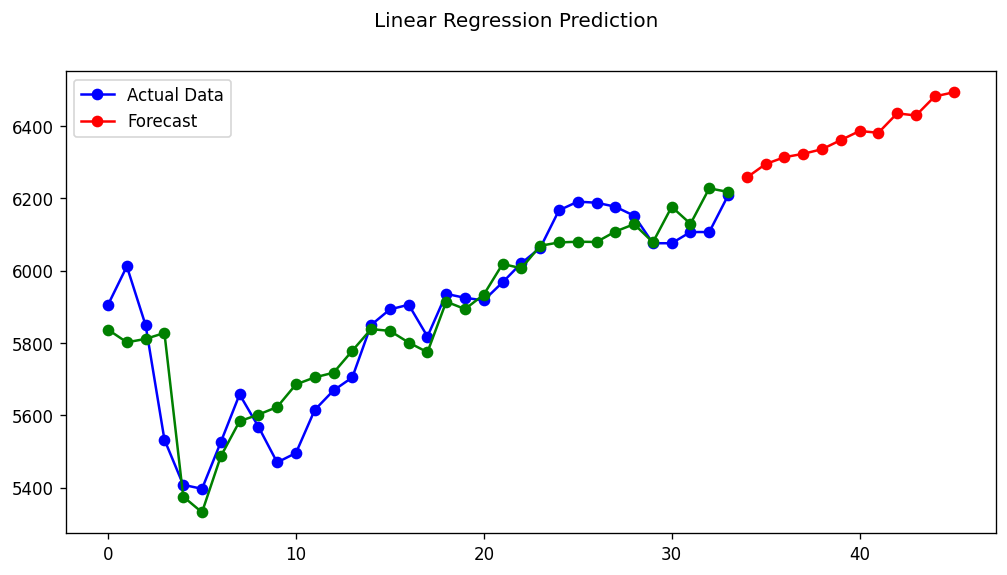

In [52]:
fig = plt.figure(figsize=(10,5))
fig.suptitle(f'Linear Regression Prediction')

actual, = plt.plot(final_df.index,final_df['ADP'], 'bo-', label='Actual Data')
predicted_IS, = plt.plot(final_df.index, IS_inputs[:,0], 'go-', label='OLS Model')
predicted_OS, = plt.plot(forecast_regressors['Date_Rank'], forecast_regressors['ADP'], 'ro-', label='Forecast')

plt.legend(handles=[actual,predicted_OS])
plt.show()

This model looks great! I will use this as our final model for the dashboard.

In [53]:
#test functions for the streamlit dashboard
def get_agg_admission_data(first_st_date_adp):
    """
    first_st_date_adp: datetime.date
        The date of the first start date 30-day period in the interval data
    """
    admit_url = 'https://data.cityofnewyork.us/resource/6teu-xtgp.json'
    # Define the SQL query separately
    sql_query = ("SELECT "
                "date_trunc_ymd(ADMITTED_DT) as admitted_dt, "
                "count(distinct INMATEID) as admission_count "
                f"WHERE ADMITTED_DT >= '{first_st_date_adp}' "
                "GROUP BY admitted_dt "
                "LIMIT 10000")

    # Encode SQL query for URL
    encoded_query = urllib.parse.quote(sql_query)

    # Construct the full URL query
    admit_query = f'{admit_url}?$query={encoded_query}'
    # Send the request and load the response data
    response = urllib.request.urlopen(admit_query)
    data = json.loads(response.read())

    # Store in dataframe
    admit_df = pd.DataFrame(data, columns=data[0].keys())
    #specify data types
    admit_df['admitted_dt'] = admit_df['admitted_dt'].astype('datetime64[ns]')
    admit_df['admission_count'] = admit_df['admission_count'].astype(int)
    #define max and min dates for future calculations
    max_date = admit_df['admitted_dt'].max()
    min_date = admit_df['admitted_dt'].min()
    #aggregate to 30 day intervals
    # Resample the DataFrame to 30-day intervals
    interval_data_adm = admit_df.resample('30D', on='admitted_dt', origin= min_date, closed='left', label='left').agg({'admission_count': 'sum'}).fillna(0).reset_index()
    # Rename columns
    interval_data_adm = interval_data_adm.rename(columns={'admitted_dt': 'Start Date', 'admission_count': 'admission_count'})
    # Calculate the Start Date column
    interval_data_adm['End Date'] = interval_data_adm['Start Date'] + pd.to_timedelta(29, unit='D')
    #add date related regressors
    interval_data_adm['Month'] = interval_data_adm['Start Date'].dt.month
    interval_data_adm['Year'] = interval_data_adm['Start Date'].dt.year
    #calculate the days between start period and last date in admission df
    interval_data_adm['Days to Max Adm Date'] = (max_date - interval_data_adm['Start Date']).dt.days
    # Display just the date portion of the start/end date columns and localize to specific timezone
    interval_data_adm['Start Date'] = interval_data_adm['Start Date'].dt.tz_localize('America/New_York').dt.date
    interval_data_adm['End Date'] = interval_data_adm['End Date'].dt.tz_localize('America/New_York').dt.date
    
    #make sure the last data point has a reasonable admission count
    #if the period has less than 30 days of admission data, we will use the avg of the last two data points
    #as the adjusted admission count for the given time period

    adj_admission_count = []
    for i, row in interval_data_adm.iterrows():
        if row['Days to Max Adm Date'] < 30:
            adj_adm_cnt = (interval_data_adm.iloc[i-1,interval_data_adm.columns.get_loc('admission_count')] +
                        interval_data_adm.iloc[i-2,interval_data_adm.columns.get_loc('admission_count')]) / 2
            adj_admission_count.append(round(adj_adm_cnt))
        else:
            adj_admission_count.append(row['admission_count'])
    interval_data_adm['Adjusted Admission Count'] = adj_admission_count
    
    _30_day_admission_df = interval_data_adm.drop(columns = 'admission_count')
    
    return _30_day_admission_df

def fit_OLS_feature_selection(data):
    """
    This function will fit the OLS model on the features selected to best optimize OS MAE.
    These features are:

    1. Date_Rank: Discrete numeric ranging from 0 to n where n is the last date period ranked in ascending order.

    2. monthly admission count

    3. adp_lag4: the average daily population 4 months prior to the current time period
    -----
    Parameters - 
    data: Pandas Dataframe
        Must have columns 'Start Date', 'End Date', and 'Total Population'
    
    Returns - 
    fc_12: Numpy array
        12 forecasted 30-day periods
    model: Numpy array
        the model fitted to the actual data
    IS_mae: float
        in sample MAE 
    """
    #step 1: retrieve the admission data
    _30_day_admission_df = get_agg_admission_data(data.iloc[0]['Start Date'].date())
    _30_day_admission_df['Start Date'] = _30_day_admission_df['Start Date'].astype('datetime64[ns, America/New_York]')
    _30_day_admission_df['End Date'] = _30_day_admission_df['End Date'].astype('datetime64[ns, America/New_York]')

    print(_30_day_admission_df.dtypes)
    print('The length of the admission data is: ', len(_30_day_admission_df))
    #step 2: join ADP interval data and admission data on Year & Month & obtain regressors
    print('The length of the original interval data is: ', len(data))
    data = data.merge(_30_day_admission_df, how = 'left', left_on = ['Start Date','End Date'], right_on = ['Start Date','End Date'])
    print('The length of the merged data is: ', len(data))
    #add a unique id for month-year ranks from earliest to latest date
    data['Date_Rank'] = data.sort_values(by = ['Year','Month']).index
    #create adp_lag4 variable
    data['adp_lag4'] = data['Total Population'].shift(4)
    #rename total population to ADP for now
    data = data.rename(columns = {'Total Population':'ADP'})
    data = data.fillna(0)
    #select only relevant data
    final_df = data[['ADP','Date_Rank','Adjusted Admission Count', 'adp_lag4']]
    print('The length of the final dataframe is: ', len(final_df))
    #step 3: Fit linear regression
    # Scale the entire dataset
    sc = MinMaxScaler()
    data_sc = sc.fit_transform(final_df)
    # Convert the array to a DataFrame
    data_sc = pd.DataFrame(data=data_sc, columns=final_df.columns)
    # Add constant to the dataset
    data_sc = sm.add_constant(data_sc, prepend=False, has_constant='add')

    # Split the dataset into features (X) and target (y)
    X = data_sc.drop(columns=['ADP'])
    y = data_sc['ADP']

    # Fit the linear regression model on the entire dataset
    ols_model = sm.OLS(y, X).fit()
    # Make in sample predictions
    IS_pred = ols_model.predict(X)

    #inverse scale the model inputs to get IS predicts
    IS_inputs = pd.concat([IS_pred,X.drop(columns=['const'])],axis = 1)
    IS_inputs = IS_inputs.rename(columns={0:'ADP'})
    IS_inputs = sc.inverse_transform(IS_inputs)

    #accuracy in terms of non-scaled values
    IS_mae = mean_absolute_error(final_df['ADP'], IS_inputs[:,0])

    #Step 4: Predict Admission Counts for next 12 time periods, propogate regressors and predict
    #predict admission using an arima model optimized in another project
    #fit model to data
    p=0
    d=1
    q=1
    order = (p,d,q)
    seasonal_order = (1,0,0,12)

    arima_model = sm.tsa.ARIMA(final_df['Adjusted Admission Count'], order=order,seasonal_order=seasonal_order)
    model_fit = arima_model.fit()
    # Perform in-sample predictions
    train_predictions = model_fit.predict()
    #forecast
    pred = model_fit.get_forecast(steps=12)
    fc_series = pd.Series(pred.summary_frame()['mean'].values)
    #create a dataframe to store prediction regressors
    forecast_regressors = pd.DataFrame(columns=final_df.columns)
    forecast_regressors['Date_Rank'] = np.arange(len(final_df),len(final_df)+12)
    #store admission predictions
    forecast_regressors['Adjusted Admission Count'] = fc_series.round()
    #adp_lag4 for the first four predictions (this is all historical adp data)
    forecast_regressors.iloc[0:4,3] = final_df['ADP'][-4:]
    #predict
    for i in range(1,4):
        #first scale first four regressors
        regressors = forecast_regressors.iloc[4*(i-1):4*i]
        #scale
        data_sc = sc.transform(regressors)
        # Convert the array to a DataFrame
        data_sc = pd.DataFrame(data=data_sc, columns=forecast_regressors.columns)
        # Add constant to the dataset
        data_sc = sm.add_constant(data_sc, prepend=False, has_constant='add')

        # Split the dataset into features (X) and target (y)
        X = data_sc.drop(columns=['ADP'])
        y = data_sc['ADP']

        OS_pred = ols_model.predict(X)
        #do the same with OS data
        OS_inputs = pd.concat([OS_pred,X.drop(columns=['const'])],axis = 1)
        OS_inputs = OS_inputs.rename(columns={0:'ADP'})
        OS_inputs = sc.inverse_transform(OS_inputs)
        #set the first four ADP in the regressor df to the predicted output
        forecast_regressors.iloc[4*(i-1):4*i,0] = OS_inputs[:,0]
        #set the next four ADP lag terms in the regressor df to the predicted output
        #exclude the last interation
        if i < 3:
            forecast_regressors.iloc[4*i:4*(i+1),3] = OS_inputs[:,0]

    fc_12 = forecast_regressors['ADP']
    return IS_inputs[:,0], fc_12, IS_mae

In [54]:
#fit and predict linear regression with selected terms
data_test = interval_data.copy()
data_test = data_test.rename(columns = {'ADP':'Total Population'})
IS_predict_OLS_selected, fc_12mo_OLS_selected, IS_MAE_selected = fit_OLS_feature_selection(data_test[['Start Date','End Date','Total Population']])


Start Date                  datetime64[ns, America/New_York]
End Date                    datetime64[ns, America/New_York]
Month                                                  int32
Year                                                   int32
Days to Max Adm Date                                   int64
Adjusted Admission Count                               int64
dtype: object
The length of the admission data is:  32
The length of the original interval data is:  32
The length of the merged data is:  32
The length of the final dataframe is:  32


In [55]:
IS_predict_OLS_selected

array([5825.03798333, 5801.65397308, 5815.95828147, 5836.28225186,
       5368.79618427, 5336.55369021, 5476.75978933, 5570.34074383,
       5594.04447973, 5618.42841997, 5675.8673543 , 5696.67588037,
       5715.27727912, 5774.75822244, 5831.38284912, 5831.81638934,
       5809.93922859, 5792.96875633, 5915.81029195, 5904.01276304,
       5944.18827041, 6023.68789191, 6018.18534073, 6077.37863082,
       6091.74448455, 6098.99129405, 6103.89359627, 6134.05554756,
       6156.15715275, 6119.51329735, 6209.44495482, 6207.39472712])

In [56]:
len(IS_predict_OLS_selected)

32

In [57]:
len(interval_data)

32

In [58]:
IS_mae

71.34708569634319

In [59]:
fc_12mo_OLS_selected

0     6249.175571
1     6303.070248
2     6317.924561
3     6350.745855
4     6369.199105
5     6385.280789
6     6403.578203
7     6431.366531
8     6459.046983
9      6458.13594
10    6511.740134
11    6523.722155
Name: ADP, dtype: object